In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
idx = pd.IndexSlice

## Data cleanup

In [90]:
laps = pd.read_pickle('data/96/merge_laps')
laps

0     Lap  Lap time Pos Tyres      Weather Temp  Hum Events
12 1    0         -   9  Soft  Very Cloudy  31°  46%      -
   2   1B  1:28.769  14  Soft  Very Cloudy  31°  46%      -
   3   2B  1:19.039  14  Soft  Very Cloudy  31°  46%      -
   4    3  1:19.700  14  Soft  Very Cloudy  31°  46%      -
   5    4  1:19.088  13  Soft  Very Cloudy  31°  46%      -
...    ..       ...  ..   ...          ...  ...  ...    ...
11 55  54  1:46.117   8  Rain         Rain  32°  86%    Pit
   56  55  2:14.593  10  Rain         Rain  31°  86%      -
   57  56  1:41.646  10  Rain         Rain  31°  86%      -
   58  57  1:40.089  10  Rain         Rain  31°  86%      -
   59  58  1:40.303  10  Rain         Rain  31°  86%      -

[322 rows x 8 columns]

In [74]:
pits = pd.read_pickle('data/96/merge_pits')
pits

Pit                          Pitstop reason Tyres condition  \
12 0  Stop 1 (Lap 19)                   No more fuel was left              9%   
   1  Stop 2 (Lap 40)                   No more fuel was left              2%   
   2  Stop 3 (Lap 47)  Tyres change due to the weather change             70%   
   3  Stop 4 (Lap 64)  Tyres change due to the weather change             31%   
10 0   Stop 1 (Lap 3)  Tyres change due to the weather change             86%   
   1  Stop 2 (Lap 22)                   No more fuel was left             34%   
   2  Stop 3 (Lap 35)                   No more fuel was left             54%   
   3  Stop 4 (Lap 48)                   No more fuel was left             53%   
13 0  Stop 1 (Lap 23)                   No more fuel was left             27%   
   1  Stop 2 (Lap 46)                   No more fuel was left             26%   
14 0  Stop 1 (Lap 25)    The tyres could not do any more laps              3%   
   1  Stop 2 (Lap 43)                   No more fuel was left             30%   
   2  Stop 3 (Lap 62)                   No more fuel was left             26%   
11 0   Stop 1 (Lap 3)  Tyres change due to the weather change             84%   
   1  Stop 2 (Lap 28)                   No more fuel was left             41%   
   2  Stop 3 (Lap 54)                   No more fuel was left             38%   

     Fuel left Refilled to Pit time  
12 0        1%   80 liters  26.222s  
   1        0%   80 liters  24.887s  
   2       30%   80 liters  31.897s  
   3       14%   80 liters  22.104s  
10 0       49%   No refill  34.035s  
   1        2%   60 liters  21.711s  
   2        0%   60 liters  26.025s  
   3        0%   60 liters  25.337s  
13 0        2%  100 liters  24.217s  
   1        2%   90 liters  26.544s  
14 0        8%   50 liters  25.946s  
   1        1%   50 liters  22.587s  
   2        1%   50 liters  25.407s  
11 0       37%   75 liters  36.748s  
   1        1%   75 liters  25.267s  
   2        0%   75 liters  27.122s

Convert columns to numeric, tyre and fuel to % of max capacity

In [75]:
pits['Pit'] = pd.to_numeric(pits['Pit'].str.split().str[-1].str[:-1])
pits['Tyres condition'] = pd.to_numeric(pits['Tyres condition'].str[:-1])/100
pits['Fuel left'] = pd.to_numeric(pits['Fuel left'].str[:-1])/100
pits['Pit time'] = pd.to_numeric(pits['Pit time'].str[:-1])
pits['Refilled to'] = (pd.to_numeric(pits['Refilled to'].str.split().str[0], 'coerce')/180).fillna(pits['Fuel left'])
pits

Pit                          Pitstop reason  Tyres condition  Fuel left  \
12 0   19                   No more fuel was left             0.09       0.01   
   1   40                   No more fuel was left             0.02       0.00   
   2   47  Tyres change due to the weather change             0.70       0.30   
   3   64  Tyres change due to the weather change             0.31       0.14   
10 0    3  Tyres change due to the weather change             0.86       0.49   
   1   22                   No more fuel was left             0.34       0.02   
   2   35                   No more fuel was left             0.54       0.00   
   3   48                   No more fuel was left             0.53       0.00   
13 0   23                   No more fuel was left             0.27       0.02   
   1   46                   No more fuel was left             0.26       0.02   
14 0   25    The tyres could not do any more laps             0.03       0.08   
   1   43                   No more fuel was left             0.30       0.01   
   2   62                   No more fuel was left             0.26       0.01   
11 0    3  Tyres change due to the weather change             0.84       0.37   
   1   28                   No more fuel was left             0.41       0.01   
   2   54                   No more fuel was left             0.38       0.00   

      Refilled to  Pit time  
12 0     0.444444    26.222  
   1     0.444444    24.887  
   2     0.444444    31.897  
   3     0.444444    22.104  
10 0     0.490000    34.035  
   1     0.333333    21.711  
   2     0.333333    26.025  
   3     0.333333    25.337  
13 0     0.555556    24.217  
   1     0.500000    26.544  
14 0     0.277778    25.946  
   1     0.277778    22.587  
   2     0.277778    25.407  
11 0     0.416667    36.748  
   1     0.416667    25.267  
   2     0.416667    27.122

Fuel and tyre used columns so we can build a linear model with 0 intercept

In [76]:
pits['Fuel used'] = pits['Refilled to'].shift(1) - pits['Fuel left']
pits.loc[idx[:, 0], 'Fuel used'] = pd.NA
pits['Tyres used'] = 1 - pits['Tyres condition']
pits[['Tyres used', 'Fuel used']]

Tyres used  Fuel used
12 0        0.91        NaN
   1        0.98   0.444444
   2        0.30   0.144444
   3        0.69   0.304444
10 0        0.14        NaN
   1        0.66   0.470000
   2        0.46   0.333333
   3        0.47   0.333333
13 0        0.73        NaN
   1        0.74   0.535556
14 0        0.97        NaN
   1        0.70   0.267778
   2        0.74   0.267778
11 0        0.16        NaN
   1        0.59   0.406667
   2        0.62   0.416667

Removed tyre per pit stop

In [77]:
pits['Tyres'] = laps.loc[zip(pits['Pit'].index.get_level_values(0), pits['Pit'] - 1), 'Tyres'].values
pits['Tyres'] = pits['Tyres'].str.split('(').str[0] # Worn tyres append a (W), remove that
pits['Tyres']

12  0          Soft
    1          Soft
    2          Soft
    3          Rain
10  0          Rain
    1        Medium
    2        Medium
    3        Medium
13  0          Hard
    1          Hard
14  0    Extra Soft
    1    Extra Soft
    2    Extra Soft
11  0    Extra Soft
    1          Rain
    2          Rain
Name: Tyres, dtype: object

Use track data to convert pit lap to km according to track in the calendar

In [78]:
tracks = pd.read_pickle('data/96/tracks')
tracks.index += 1
tracks['Lap distance'] = pd.to_numeric(tracks['Lap distance'].str.split().str[0])
tracks

,Track name,Country,Kms,Laps,Lap distance,Power,Handling,Acceleration,Category,GPs held
1,Interlagos,Brazil,305.9,71,4.308,NaN,NaN,NaN,F1,33
2,Melbourne,Australia,307.6,58,5.303,NaN,NaN,NaN,F1,33
3,Mexico City,Mexico,305.0,69,4.420,NaN,NaN,NaN,F1,41
4,Buenos Aires,Argentina,306.6,72,4.258,NaN,NaN,NaN,ex F1,35
5,Las Vegas,United States,305.9,50,6.118,NaN,NaN,NaN,F1,1
6,Fuji,Japan,305.4,67,4.558,NaN,NaN,NaN,ex F1,36
7,Yas Marina,United Arab Emirates,305.5,55,5.555,NaN,NaN,NaN,F1,39
8,Shanghai,China,305.2,56,5.450,NaN,NaN,NaN,F1,36
9,Istanbul,Turkey,309.4,58,5.334,NaN,NaN,NaN,ex F1,36
10,Sepang,Malaysia,310.4,55,5.644,NaN,NaN,NaN,ex F1,39


In [79]:
pits['Distance'] = tracks.loc[pits.index.get_level_values(0).astype(int), 'Lap distance'].values*pits['Pit'].values
pits['Distance']

12  0     86.887
    1    182.920
    2    214.931
    3    292.672
10  0     16.932
    1    124.168
    2    197.540
    3    270.912
13  0    124.292
    1    248.584
14  0     79.650
    1    136.998
    2    197.532
11  0     15.741
    1    146.916
    2    283.338
Name: Distance, dtype: float64

Create 'Delta' column with Kms before each pit stop

In [80]:
pits['Delta'] = pits['Distance'].diff()
pits.loc[idx[:, 0], 'Delta'] = pits.loc[idx[:, 0], 'Distance']
pits

Pit                          Pitstop reason  Tyres condition  Fuel left  \
12 0   19                   No more fuel was left             0.09       0.01   
   1   40                   No more fuel was left             0.02       0.00   
   2   47  Tyres change due to the weather change             0.70       0.30   
   3   64  Tyres change due to the weather change             0.31       0.14   
10 0    3  Tyres change due to the weather change             0.86       0.49   
   1   22                   No more fuel was left             0.34       0.02   
   2   35                   No more fuel was left             0.54       0.00   
   3   48                   No more fuel was left             0.53       0.00   
13 0   23                   No more fuel was left             0.27       0.02   
   1   46                   No more fuel was left             0.26       0.02   
14 0   25    The tyres could not do any more laps             0.03       0.08   
   1   43                   No more fuel was left             0.30       0.01   
   2   62                   No more fuel was left             0.26       0.01   
11 0    3  Tyres change due to the weather change             0.84       0.37   
   1   28                   No more fuel was left             0.41       0.01   
   2   54                   No more fuel was left             0.38       0.00   

      Refilled to  Pit time  Fuel used  Tyres used       Tyres  Distance  \
12 0     0.444444    26.222        NaN        0.91        Soft    86.887   
   1     0.444444    24.887   0.444444        0.98        Soft   182.920   
   2     0.444444    31.897   0.144444        0.30        Soft   214.931   
   3     0.444444    22.104   0.304444        0.69        Rain   292.672   
10 0     0.490000    34.035        NaN        0.14        Rain    16.932   
   1     0.333333    21.711   0.470000        0.66      Medium   124.168   
   2     0.333333    26.025   0.333333        0.46      Medium   197.540   
   3     0.333333    25.337   0.333333        0.47      Medium   270.912   
13 0     0.555556    24.217        NaN        0.73        Hard   124.292   
   1     0.500000    26.544   0.535556        0.74        Hard   248.584   
14 0     0.277778    25.946        NaN        0.97  Extra Soft    79.650   
   1     0.277778    22.587   0.267778        0.70  Extra Soft   136.998   
   2     0.277778    25.407   0.267778        0.74  Extra Soft   197.532   
11 0     0.416667    36.748        NaN        0.16  Extra Soft    15.741   
   1     0.416667    25.267   0.406667        0.59        Rain   146.916   
   2     0.416667    27.122   0.416667        0.62        Rain   283.338   

        Delta  
12 0   86.887  
   1   96.033  
   2   32.011  
   3   77.741  
10 0   16.932  
   1  107.236  
   2   73.372  
   3   73.372  
13 0  124.292  
   1  124.292  
14 0   79.650  
   1   57.348  
   2   60.534  
11 0   15.741  
   1  131.175  
   2  136.422

## Fuel and tyres usage estimation

Linearly model tyre and fuel % use per lap, have to omit first stops for fuel use since they have NaNs (will fix once starting fuel is scrapped).

In [81]:
colors = {'Extra Soft': 'pink', 'Soft': 'red', 'Medium': 'yellow', 'Hard': 'grey', 'Rain': 'blue'}
tyres = colors.keys()

In [82]:
usage = pd.DataFrame([], tyres, ['N', 'Usage'])
for tyre, data in pits.groupby('Tyres'):
    delta = data['Delta'].to_numpy()[:, np.newaxis]
    usage.loc[tyre] = [len(data), np.linalg.lstsq(delta, data['Tyres used'], rcond=None)[0][0]]

delta = pits['Delta'].to_numpy()[:, np.newaxis]
usage = pd.concat([usage, ])
mf = np.linalg.lstsq(delta[pits['Fuel used'].notna()], pits['Fuel used'][pits['Fuel used'].notna()], rcond=None)[0][0]
usage.loc['Fuel'] = [len(pits['Fuel used'].notna()), mf]

usage

,N,Usage
Extra Soft,4,0.012161
Soft,3,0.010271
Medium,3,0.006243
Hard,2,0.005913
Rain,4,0.005172
Fuel,16.0,0.003912


In [83]:
usage.loc['Soft', 'Usage']

0.010270779055422377

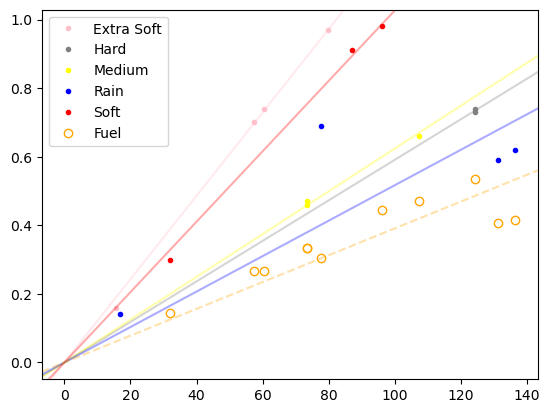

In [84]:
for tyre, data in pits.groupby('Tyres'):
    plt.plot(data['Delta'], data['Tyres used'], '.', label = tyre, c = colors[tyre])
    plt.axline((0, 0), slope = usage.loc[tyre, 'Usage'], c = colors[tyre], alpha = 0.33)

plt.plot(pits['Delta'], pits['Fuel used'], 'o', label = 'Fuel', c = 'orange', fillstyle = 'none')
plt.axline((0, 0), slope = mf, c = 'orange', alpha = 0.33, linestyle = '--')

plt.legend()

Export usage data for [strategies.ipynb](strategies.ipynb)

In [85]:
import pickle
with open('data/tyres', 'wb') as file:
    pickle.dump(usage, file)

## Pitstop time estimation

In [86]:
pits

Pit                          Pitstop reason  Tyres condition  Fuel left  \
12 0   19                   No more fuel was left             0.09       0.01   
   1   40                   No more fuel was left             0.02       0.00   
   2   47  Tyres change due to the weather change             0.70       0.30   
   3   64  Tyres change due to the weather change             0.31       0.14   
10 0    3  Tyres change due to the weather change             0.86       0.49   
   1   22                   No more fuel was left             0.34       0.02   
   2   35                   No more fuel was left             0.54       0.00   
   3   48                   No more fuel was left             0.53       0.00   
13 0   23                   No more fuel was left             0.27       0.02   
   1   46                   No more fuel was left             0.26       0.02   
14 0   25    The tyres could not do any more laps             0.03       0.08   
   1   43                   No more fuel was left             0.30       0.01   
   2   62                   No more fuel was left             0.26       0.01   
11 0    3  Tyres change due to the weather change             0.84       0.37   
   1   28                   No more fuel was left             0.41       0.01   
   2   54                   No more fuel was left             0.38       0.00   

      Refilled to  Pit time  Fuel used  Tyres used       Tyres  Distance  \
12 0     0.444444    26.222        NaN        0.91        Soft    86.887   
   1     0.444444    24.887   0.444444        0.98        Soft   182.920   
   2     0.444444    31.897   0.144444        0.30        Soft   214.931   
   3     0.444444    22.104   0.304444        0.69        Rain   292.672   
10 0     0.490000    34.035        NaN        0.14        Rain    16.932   
   1     0.333333    21.711   0.470000        0.66      Medium   124.168   
   2     0.333333    26.025   0.333333        0.46      Medium   197.540   
   3     0.333333    25.337   0.333333        0.47      Medium   270.912   
13 0     0.555556    24.217        NaN        0.73        Hard   124.292   
   1     0.500000    26.544   0.535556        0.74        Hard   248.584   
14 0     0.277778    25.946        NaN        0.97  Extra Soft    79.650   
   1     0.277778    22.587   0.267778        0.70  Extra Soft   136.998   
   2     0.277778    25.407   0.267778        0.74  Extra Soft   197.532   
11 0     0.416667    36.748        NaN        0.16  Extra Soft    15.741   
   1     0.416667    25.267   0.406667        0.59        Rain   146.916   
   2     0.416667    27.122   0.416667        0.62        Rain   283.338   

        Delta  
12 0   86.887  
   1   96.033  
   2   32.011  
   3   77.741  
10 0   16.932  
   1  107.236  
   2   73.372  
   3   73.372  
13 0  124.292  
   1  124.292  
14 0   79.650  
   1   57.348  
   2   60.534  
11 0   15.741  
   1  131.175  
   2  136.422

,N,Average
No more fuel was left,11,25.029636
Tyres change due to the weather change,4,31.196
The tyres could not do any more laps,1,25.946


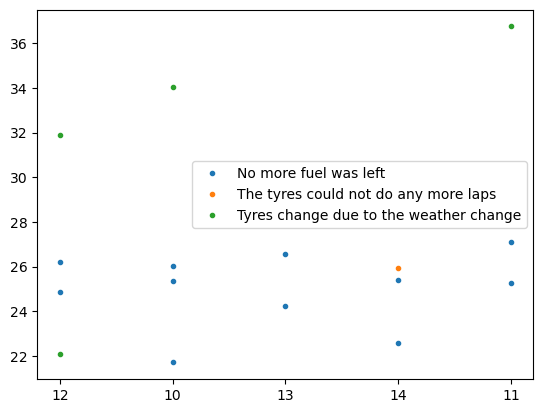

In [87]:
pitstime = pd.DataFrame([], pits['Pitstop reason'].unique(), ['N', 'Average'])
for reason, data in pits.groupby('Pitstop reason'):
    pitstime.loc[reason] = [len(data), data['Pit time'].mean()]
    plt.plot(data.index.get_level_values(0), data['Pit time'], '.', label = reason)
plt.legend()
pitstime

In [88]:
with open('data/pitstime', 'wb') as file:
    pickle.dump(pitstime, file)